In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import cbsodata # CBS Open Data Python package of Statistiek Netherlands
import matplotlib.pyplot as plt

import h3pandas
import h3

In [3]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'helvetica'

In [6]:
# Retrieve the municipal boundaries map from PDOK
geodata_url = 'https://geodata.nationaalgeoregister.nl/cbsgebiedsindelingen/wfs?request=GetFeature&service=WFS&version=2.0.0&typeName=cbs_gemeente_2017_gegeneraliseerd&outputFormat=json'
gemeentegrenzen = gpd.read_file(geodata_url)

# CBS data
data = pd.DataFrame(cbsodata.get_data("83765NED", select = ['WijkenEnBuurten', 'Codering_3', "MateVanStedelijkheid_104"]))
data['Codering_3'] = data['Codering_3'].str.strip()

# link Statistics Netherlands data to geodata with region codes
gemeentegrenzen = pd.merge(
    gemeentegrenzen, 
    data,
    left_on = "statcode",
    right_on = "Codering_3"
)

Source https://stackoverflow.com/questions/63516948/how-to-convert-shapefile-geojson-to-hexagons-using-uber-h3-in-python

In [25]:
# conversion to hex grid (first projecting to lon-lat)
gemeentegrenzen_c=gemeentegrenzen.to_crs('epsg:4326').h3.polyfill(7, explode=True)
gemeentegrenzen_c=gemeentegrenzen_c.dropna(subset=['h3_polyfill'])
gdf_h3 = gemeentegrenzen_c.set_index('h3_polyfill').h3.h3_to_geo_boundary()
gdf_h3["MateVanStedelijkheid_104"]*=-1

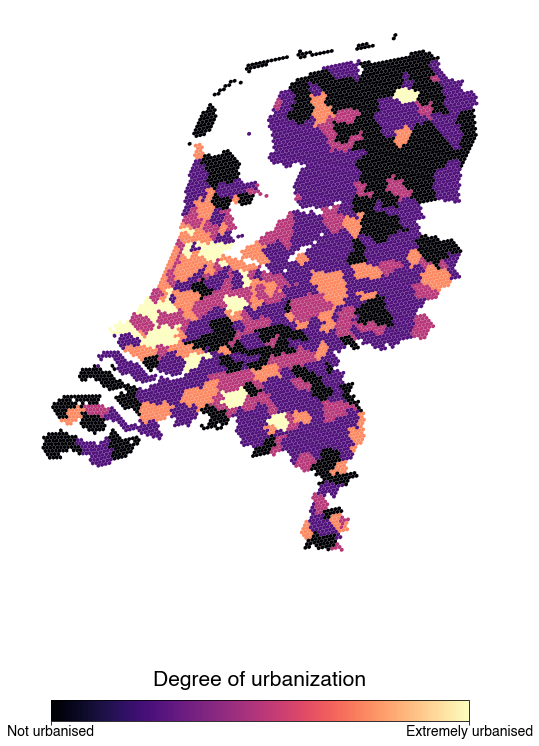

In [35]:
# plot
fig, ax = plt.subplots(1,1,figsize=(15,15))

gdf_h3.plot(
    ax = ax,
    column=var_plot,
    cmap='magma',
    legend=True,
    legend_kwds={
        'orientation': "horizontal",
        'shrink': 0.5,
        'ticks': [-5,-1]
    }
)

# colorbar formatting
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14,pad=0.2)
xticks = cb_ax.get_xticks()
dict_urb={-1: "Extremely urbanised",-5:'Not urbanised'}
cb_ax.set_xticklabels([x if x not in dict_urb else dict_urb[x] for x in xticks])

# title and axis removal
ax.set_title('Degree of urbanization',fontsize=21, y=-0.2)
ax.axis('off')

plt.savefig('challenge_hex4.jpg',bbox_inches='tight')